In [69]:
import pandas as pd
import matplotlib.pyplot as plt
financial = pd.read_csv('financial_data.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', None)

month_rename = {
    'Ноябрь 2022': '2022-11', 'Декабрь 2022': '2022-12', 'Январь 2023': '2023-01',
    'Февраль 2023': '2023-02', 'Март 2023': '2023-03', 'Апрель 2023': '2023-04',
    'Май 2023': '2023-05', 'Июнь 2023': '2023-06', 'Июль 2023': '2023-07',
    'Август 2023': '2023-08', 'Сентябрь 2023': '2023-09', 'Октябрь 2023': '2023-10',
    'Ноябрь 2023': '2023-11', 'Декабрь 2023': '2023-12', 'Январь 2024': '2024-01',
    'Февраль 2024': '2024-02'}

In [70]:
# Переименовываем колонки
financial.rename(columns=month_rename, inplace=True)
financial.rename(columns={'Причина дубля': 'reason_for_duplication'}, inplace=True)

# Заменяем "стоп", "end" и "в ноль" на None во всех колонках
financial_filtered = financial.replace(['стоп', 'end'], None)
financial_filtered = financial_filtered.replace("в ноль", "0")

In [71]:
month_cols = [
    '2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04',
    '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10',
    '2023-11', '2023-12', '2024-01', '2024-02']

# Преобразуем в строки
financial_filtered[month_cols] = financial_filtered[month_cols].astype(str)

# Удалим всё лишнее кроме цифр, запятой, минуса и точки
financial_filtered[month_cols] = financial_filtered[month_cols].apply(
    lambda x: x.str.replace(r'[^\d,.-]', '', regex=True))

# Заменим запятые на точки
financial_filtered[month_cols] = financial_filtered[month_cols].apply(lambda x: x.str.replace(',', '.'))

# Преобразуем к числовому типу
financial_filtered[month_cols] = financial_filtered[month_cols].apply(pd.to_numeric, errors='coerce')

In [72]:
# Группируем данные по 'id' и 'Account', суммируем платежные столбцы
df_grouped = financial_filtered.groupby(['id', 'Account'], as_index=False).agg({col: 'sum' for col in month_cols})

# Группируем по каждому менеджеру и считаем сумму его проектов
grouped = df_grouped.groupby('Account')[month_cols].sum()

In [73]:
# Считаем коэффициент пролонгации в первый месяц (K1)
k1 = grouped.shift(-1, axis=1) / grouped
k1 = k1.round(2)
k1.drop(columns=['2022-11', '2022-12', '2024-01', '2024-02'], inplace=True)
# Заменим inf на NaN, чтобы избежать проблем при суммировании
k1.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# Рассчитываем коэффициент K1 за год для каждого менеджера
k1_yearly = k1.sum(axis=1, skipna=True)
print("\nK1 за год для каждого менеджера:")
print(k1_yearly)

# Рассчитываем коэффициент K1 за год для отдела (сумма по всем менеджерам)
# Обрабатываем NaN при суммировании
k1_year = k1_yearly.sum(skipna=True)
print(f"\nK1 за 2023 год для отдела: {round(k1_year, 2)}")


K1 за год для каждого менеджера:
Account
Менеджер A    12.61
Менеджер B     1.11
Менеджер C    11.64
Менеджер D     9.37
Менеджер E    10.38
Менеджер F    12.48
Менеджер G    12.07
Менеджер H     7.64
Менеджер I    11.73
без А/М         0.0
dtype: object

K1 за 2023 год для отдела: 89.03


In [74]:
# Месяцы для расчета K2
months_2023 = ['2023-01', '2023-02', '2023-03', '2023-04', '2023-05',
               '2023-06', '2023-07', '2023-08', '2023-09', '2023-10',
               '2023-11', '2023-12']

# Считаем коэффициент пролонгации в первый месяц (K2)
k2_by_manager = {}
# Проходим по каждому менеджеру
for manager in df_grouped['Account'].unique():
    manager_data = df_grouped[df_grouped['Account'] == manager]

    k2_monthly = {}

    for i in range(len(months_2023) - 1):
        first_month = months_2023[i]
        second_month = months_2023[i + 1]

        # Строки, где в первом месяце отгрузки не было
        no_first_month = manager_data[manager_data[first_month] == 0].copy()

        # Сумма отгрузки во втором месяце
        sum_second_month = no_first_month[second_month].sum()

        # Ищем последний месяц с отгрузкой
        no_first_month['last_month_val'] = 0.0
        for index, row in no_first_month.iterrows():
            for month in reversed(months_2023):
                value = row[month]
                if pd.notna(value) and value != 0:
                    no_first_month.at[index, 'last_month_val'] = value
                    break

        # Сумма последних месяцев
        sum_last = no_first_month['last_month_val'].sum()

        # Считаем K2
        if sum_last != 0:
            k2_value = sum_second_month / sum_last
            k2_monthly[first_month] = round(k2_value, 2)
        else:
            k2_monthly[first_month] = None

    # Сохраняем для менеджера
    k2_by_manager[manager] = k2_monthly

k2 = pd.DataFrame(k2_by_manager).T

# Рассчитываем коэффициент K2 за год для каждого менеджера
k2_yearly = k2.sum(axis=1, skipna=True)
print("\nK2 за год для каждого менеджера:")
print(k2_yearly)

# Рассчитываем коэффициент K2 за год для каждого менеджера
# Обрабатываем NaN при суммировании
k2_year = k2_yearly.sum(skipna=True)
print(f"\nK2 за 2023 год для отдела: {round(k2_year, 2)}")

k2['Account'] = k2.index
k2 = k2.reset_index(drop=True)
k2 = k2.sort_values('Account')
k2 = k2.set_index('Account')



K2 за год для каждого менеджера:
Менеджер E    0.66
Менеджер C    1.50
Менеджер G    1.41
Менеджер F    2.25
Менеджер A    1.59
Менеджер D    0.98
Менеджер I    1.24
Менеджер H    2.50
без А/М       1.00
Менеджер B    0.90
dtype: float64

K2 за 2023 год для отдела: 14.03


In [75]:
print(k1)
print(k2)

            2023-01  2023-02  2023-03 2023-04  2023-05  2023-06  2023-07  2023-08  2023-09 2023-10  2023-11  2023-12
Account                                                                                                             
Менеджер A     1.19     1.53     0.91    1.54     0.71     1.06     0.97     1.11     1.07    1.08     0.75     0.69
Менеджер B      NaN      NaN      NaN     NaN      NaN      NaN      NaN      NaN      NaN    <NA>     1.11     0.00
Менеджер C     1.19     1.09     1.03    0.88     1.08     0.97     1.06     0.91     1.04    0.81     1.00     0.58
Менеджер D     1.06     0.69     0.65    1.32     0.76     1.01     0.96     0.97     0.52    0.71     0.72     0.00
Менеджер E     0.85     0.95     0.66    1.34     0.80     0.62     0.42     0.74     1.00     1.0     1.00     1.00
Менеджер F     1.21     1.13     1.00    1.12     1.00     1.22     1.17     0.96     1.05    1.02     0.93     0.67
Менеджер G     0.94     1.23     1.21    1.05     0.99     1.09 

In [76]:
# Для наглядности сделаем визуализацию в matplotlib
# Данные K1 за год по менеджерам
k1_by_manager = {
    "Менеджер C": 11.64,
    "Менеджер E": 10.38,
    "Менеджер A": 12.61,
    "Менеджер D": 9.37,
    "Менеджер B": 1.11,
    "Менеджер G": 12.07,
    "Менеджер F": 12.48,
    "Менеджер I": 11.73,
    "Менеджер H": 7.64
}

# Данные K2 за год по менеджерам
k2_by_manager = {
    'Менеджер E': 0.66,
    'Менеджер C': 1.50,
    'Менеджер G': 1.41,
    'Менеджер F': 2.25,
    'Менеджер A': 1.59,
    'Менеджер D': 0.98,
    'Менеджер I': 1.24,
    'Менеджер H': 2.50,
    'Менеджер B': 0.90
}

# Сортируем коэффициенты менеджеров по убыванию
k1_by_manager = dict(sorted(k1_by_manager.items(), key=lambda x: x[1], reverse=True))
k2_by_manager = dict(sorted(k2_by_manager.items(), key=lambda x: x[1], reverse=True))

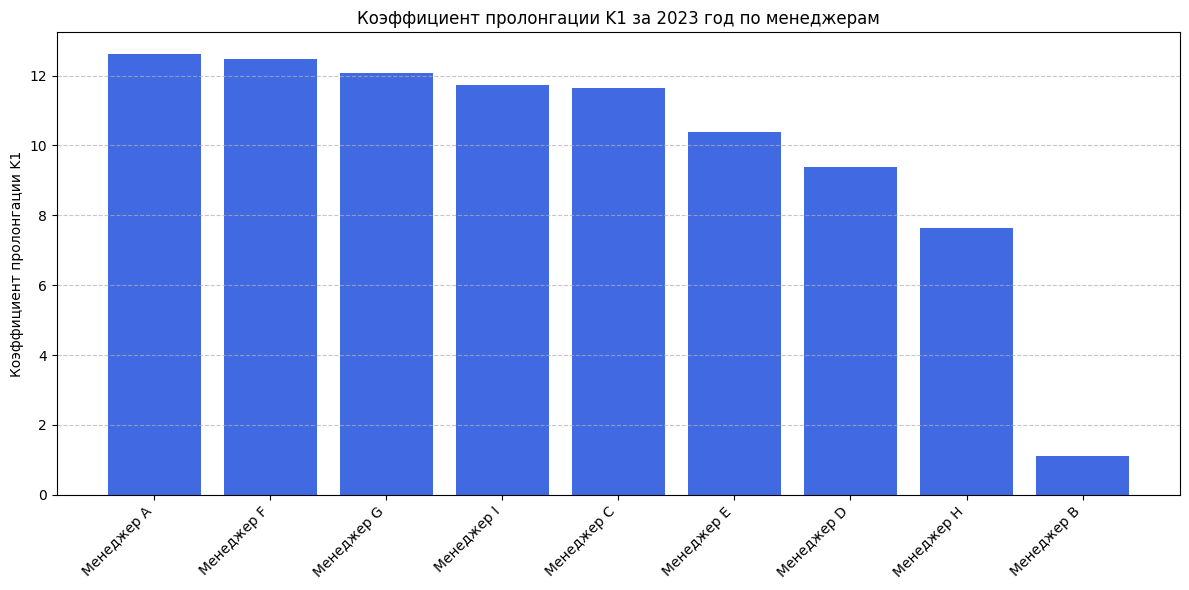

In [77]:
# График K1 по менеджерам
plt.figure(figsize=(12, 6))
plt.bar(k1_by_manager.keys(), k1_by_manager.values(), color='royalblue')
plt.title("Коэффициент пролонгации K1 за 2023 год по менеджерам")
plt.ylabel("Коэффициент пролонгации K1")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

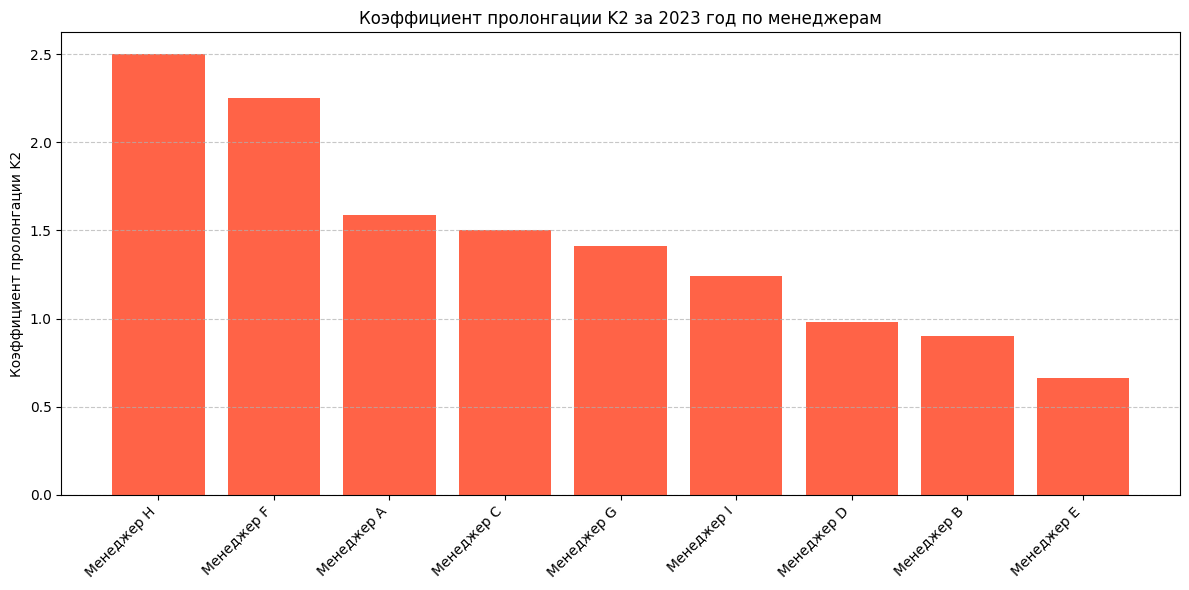

In [78]:
# График K2 по менеджерам
plt.figure(figsize=(12, 6))
plt.bar(k2_by_manager.keys(), k2_by_manager.values(), color='tomato')
plt.title("Коэффициент пролонгации K2 за 2023 год по менеджерам")
plt.ylabel("Коэффициент пролонгации K2")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

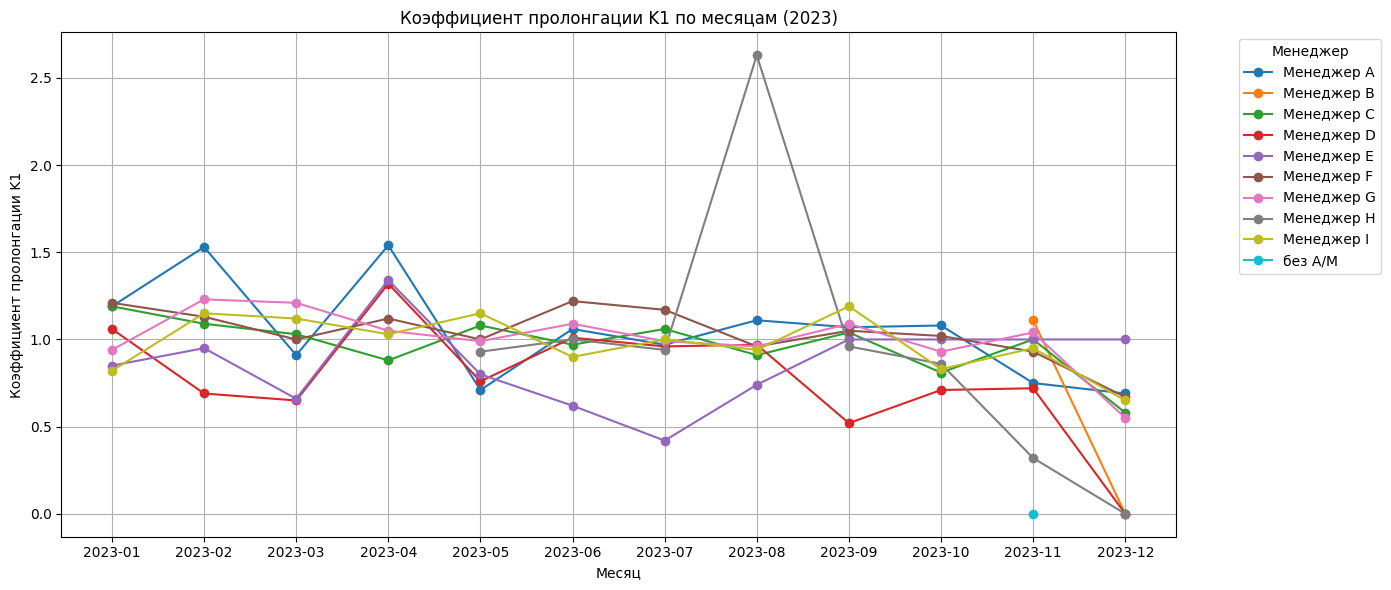

In [79]:
# Для графика K1 по месяцам
k1_reset = k1.reset_index()
plt.figure(figsize=(14, 6))
for manager in k1_reset['Account'].unique():
    manager_data = k1_reset[k1_reset['Account'] == manager]
    manager_data_clean = manager_data.dropna(axis=1, how='any')
    if len(manager_data_clean.columns) > 1:
        plt.plot(manager_data_clean.columns[1:], manager_data_clean.iloc[0, 1:], marker='o', label=manager)

plt.title('Коэффициент пролонгации K1 по месяцам (2023)')
plt.xlabel('Месяц')
plt.ylabel('Коэффициент пролонгации K1')
plt.legend(title='Менеджер', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

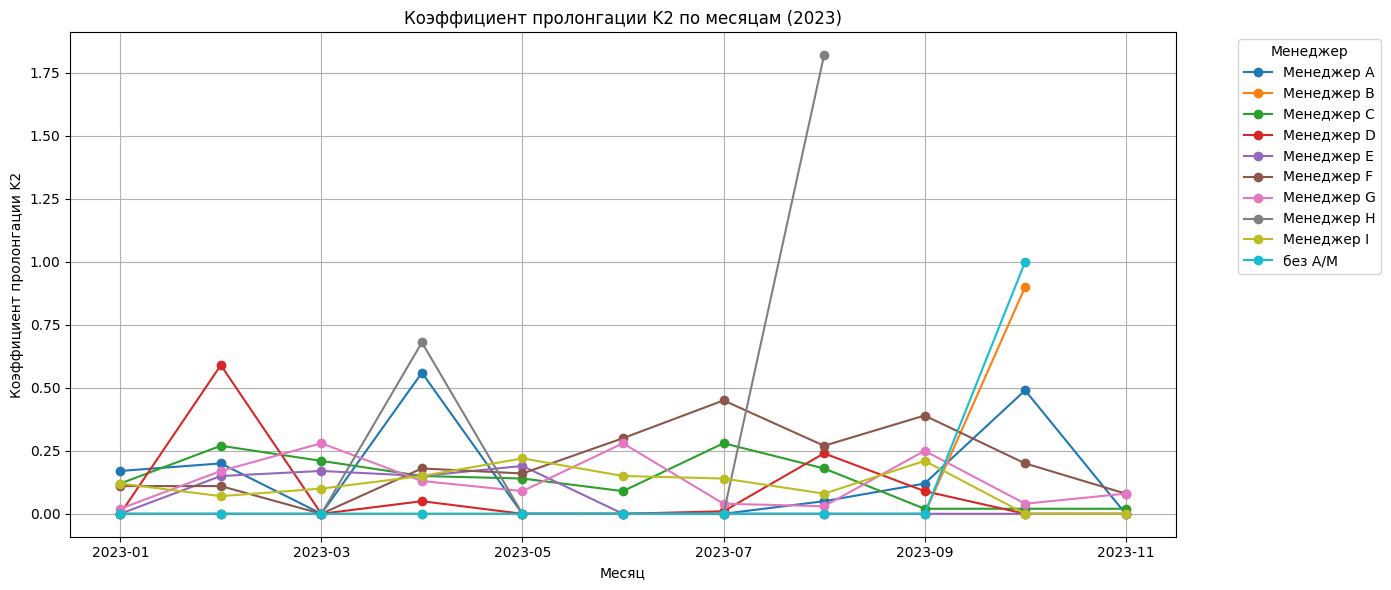

In [80]:
# Для графика K2 по месяцам
k2.T.plot(figsize=(14, 6), marker='o')
plt.title('Коэффициент пролонгации K2 по месяцам (2023)')
plt.xlabel('Месяц')
plt.ylabel('Коэффициент пролонгации K2')
plt.grid(True)
plt.legend(title='Менеджер', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()